# Image Manipulation 
## Using a Fast Neural Style Transfer Model
Another popular computer vision use-case is image manipulation. 

In this example, we use another model from the ONNX Model Zoo repository, using a Fast Neural Style Transfer network to apply a mosaic effect to images.

In [1]:
from PIL import Image, ImageOps
import numpy as np
import onnx
import onnxruntime as rt

import swat
from swat import CASTable

### Connect to CAS

In [2]:
# %%
portnum = # <CAS port number>
host = # "<CAS host name>"
user = # "<USER>""
s = swat.CAS(host, portnum,user)

### Load ONNX file to CAS

ONNX file from https://github.com/onnx/models/tree/master/vision/style_transfer/fast_neural_style

In [3]:
# model path
onnxfile = "mosaic-9.onnx"

# Read ONNX
s.loadactionset('aStore')
with open(onnxfile,'rb') as file:
    blob = file.read()
blob_ = swat.blob(blob)

# Check ONNX 
s.aStore.check(onnx=blob_)

# Describe ONNX
res = s.aStore.describe(onnx=blob_)
print(res)

NOTE: Added action set 'aStore'.
NOTE: It is a valid ONNX model
[AStore.Tab.Description]

 Basic Information
 
               Attribute    Value
 0            IR Version        4
 1         Model Version        0
 2                Domain         
 3            Doc String         
 4         Producer Name  pytorch
 5      Producer Version      1.1
 6   Operator Set Domain         
 7  Operator Set Version        9

[AStore.Tab.InputValueInfo]

 Input Information
 
      Name    Length ValueType             Shape ElementType
 0  input1  602112.0    Tensor  (1, 3, 224, 224)       FLOAT

[AStore.Tab.OutputValueInfo]

 Output Information
 
       Name    Length ValueType             Shape ElementType
 0  output1  602112.0    Tensor  (1, 3, 224, 224)       FLOAT

+ Elapsed: 0.0248s, user: 0.00675s, sys: 0.018s, mem: 0.844mb


The ODS tables from the describe action shows that the input is a 3-channel, 224x224 pixel image, the same as in the VGG example. Since this is an image manipulation task, the output is the same image with effects applied, so the length and shape are the same. 

### Load images and resize them
Resize the images to 224x224

In [4]:
# load images
s.loadactionset('image')

s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='data',
                  path='/path/to/data',
                  subdirectories=True)
s.image.loadimages(
    path='images',
    caslib='data',
    decode=True,
    addColumns=["CHANNELCOUNT", "CHANNELTYPE", "HEIGHT", "WIDTH"],
    casout=dict(name='imagesOrig', replication=0, replace=True),
)

NOTE: Added action set 'image'.
NOTE: Cloud Analytic Services added the caslib 'data'.
NOTE: Loaded 10 images from /path/to/data/images into Cloud Analytic Services table imagesOrig.


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasuser),imagesOrig,10,12,"CASTable('imagesOrig', caslib='CASUSER(sasuser)')"


In [5]:
# no padding or letterbox resizing, just resize to 224x224
encodedImage = True
inputColorOrder = 'RGB'

s.image.processimages(
    table='imagesOrig',
    imagefunctions=[
         dict(functionoptions=dict(functiontype='resize', w=224, h=224))
         ,
         {'options': {'functiontype': 'CONVERT_COLOR', 'type': 'BGR2RGB'}}
       ],
    decode=not encodedImage,
    copyvars=['_height_','_width_'],
    casout=dict(name='imagesResized',replace=True)
)

NOTE: The table IMAGESORIG contains decoded images.
NOTE: 10 of 10 images were processed successfully and saved as encoded images to the Cloud Analytic Services table imagesResized.


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasuser),imagesResized,10,7,"CASTable('imagesResized', caslib='CASUSER(mace..."


### Save ONNX to ASTORE
The saveas action call looks similar to the other examples. In most examples, the main differences will be the input and output values, and any normalization that may be needed. 

In [6]:
s.aStore.saveas(
           table="imagesResized",
           rstore=dict(name="mosaicStore", replace=True),
           onnx=blob_,
           inputs=[dict(vars=["_image_"],shape=[1,3,224,224],varbinaryType="UINT8", 
                        inputShapeOrder='NHWC', inputColorOrder='RGB',
                        modelShapeOrder='NCHW', modelColorOrder='RGB',
                        preprocess='NORMALIZE', normFactor=255)],
            outputs=[dict(name="output", shape=[1,3,224,224])],
           )

NOTE: 6734467 bytes were written to the table "mosaicStore" in the caslib "CASUSER(sasuser)".


+ Elapsed: 0.0811s, user: 0.0513s, sys: 0.0278s, mem: 16.9mb

### Describe newly generate ASTORE

In [7]:
s.aStore.describe(rstore="mosaicStore")

[Key]

 Store Key
 
                                         Key
 0  3521F08C4C6AED5A195BD711329640772CE5FC94

[Description]

 Basic Information
 
          Attribute               Value
 0  Analytic Engine                onnx
 1     Time Created  23Nov2021:16:51:35

[InputVariables]

 Input Variables
 
       Name   Length Role Type    RawType FormatName
 0  _image_  39221.0   Id       Character           

[OutputVariables]

 Output Variables
 
        Name    Length       Type              Label
 0  P_output  602112.0  Character  Predicted: output

+ Elapsed: 0.0443s, user: 0.0442s, mem: 5.39mb

### Score image data with the ASTORE
Now score the input images using the new store "mosaicStore"

In [8]:
# score 
s.aStore.score(rstore="mosaicStore", table="imagesResized", out=dict(name="out",replace=True), copyvars=("_path_","_id_"))

[OutputCasTables]

             casLib Name  Rows  Columns  \
 0  CASUSER(sasuser)  out    10        3   
 
                                     casTable  
 0  CASTable('out', caslib='CASUSER(sasuser)')  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.000130  0.000492
 1  Creating the State  0.094295  0.357196
 2             Scoring  0.169108  0.640592
 3               Total  0.263987  1.000000

+ Elapsed: 0.31s, user: 8.82s, sys: 0.491s, mem: 190mb

The resulting output table “out” contains the variable “P_output” (as specified in the saveas action), which contains image data in binary format. A sample of what this looks like:

In [9]:
s.CASTable("out").head()

,P_output,_path_,_id_
0,"b'n\xf3\x06C""Y\xfdBB\x95\xfeB\x9c$\x03C\x0bd\x...",/path/to/data/images/image7.jpg,1
1,b'\x19\xd67Cc\x821C\x10YHC_2YC\x05\x19MC\xff\x...,/path/to/data/images/image0.jpg,2
2,b'\xf9\x8aFCYdHC|\xf8DC(\x00QC<\xad[C \x8f[C\x...,/path/to/data/images/image10.jpg,3
3,"b'\xb3+\x10C\xf8\x15\x14C\xd7R\x17C&,\xdcB\xa5...",/path/to/data/images/image15.jpg,4
4,b'^T:C\xff\xde=C\xf2gECG\xb5DC\xcd\xe7CC\xa9$A...,/path/to/data/images/image16.jpg,5


### Post-process to view the output images
It is useful to run these actions in Python so we can utilize other Python modules for image processing, such as the PIL Image package for reading image data. Some post-processing is required for this example, but the post-processing is specified in the Model Zoo entry for this model, so almost no effort is required on our part. 

In [10]:
def post_process(data):
    bindata = np.frombuffer(data,dtype='<f4')
    result = np.clip(bindata, 0, 255)
    result = np.reshape(result, (3,224,224))
    result = result.transpose(1,2,0).astype("uint8")
    img = Image.fromarray(result)
    return img

In this case, the input data is the P_output image data. Finally, convert the CASTable to a dictionary, run the post-processing on the image, and display the image.

In [11]:
image_data = s.CASTable("out").to_dict()

In [12]:
images = []
for i in range(len(image_data['_id_'])):
    data = image_data['P_output'][i]
    id_ = image_data['_id_'][i]
    img = post_process(data)
    images.append((img,id_))

Display images

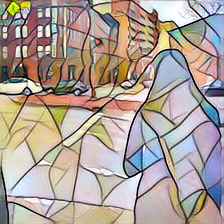

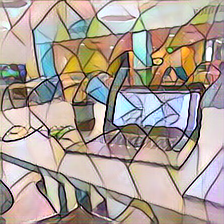

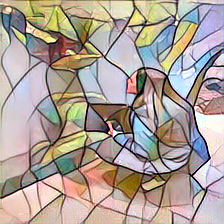

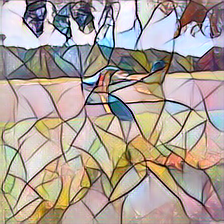

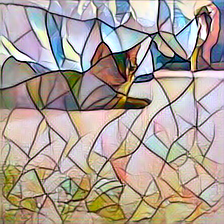

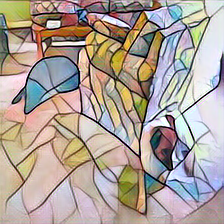

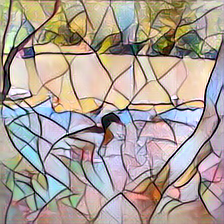

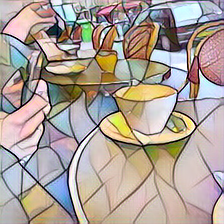

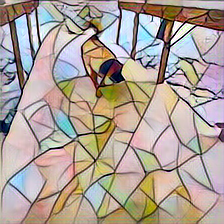

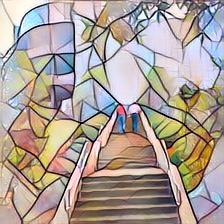

In [13]:
for img in images:
    display(img[0])

### Extract the model
To extract and save the ONNX model from rstore and save locally, a user can do so with the extract action.

The model is extracted into “mosaic_extracted.onnx” and has the same properties as the original ONNX model.

In [ ]:
# Extract the model
onnxout = s.aStore.extract(
    rstore= "mosaicStore"
)

# Save the extracted ONNX
onnxfile = "mosaic_extracted.onnx"
with open(onnxfile, 'wb') as file:
    file.write(onnxout['blob'])
